In [1]:
import pandas as pd
import numpy as np
import os
import pydicom
import gdcm
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Load the CSV file
data_path = 'U:/GitHub/AI-ethnicity-med-image/data/NLST_CT_withPID.csv'
df = pd.read_csv(data_path)

In [3]:
# Clean the DataFrame by removing any unnecessary rows or columns
df_cleaned = df.dropna(how='all', axis=1)  # Remove empty columns

# Define the mapping for the selected categories
race_mapping = {
    1: "White",
    2: "Black or African-American",
    3: "Asian",
    4: "American Indian or Alaskan Native",
    5: "Native Hawaiian or Other Pacific Islander"
}

# Map the 'Patient Race' column to the corresponding strings
df_cleaned['Patient Race'] = df_cleaned['Patient Race'].map(race_mapping)

# Drop rows where 'Patient Race' is NaN (which corresponds to excluded categories)
df_cleaned = df_cleaned.dropna(subset=['Patient Race'])

# Ensure unique patients
unique_patients = df_cleaned.drop_duplicates(subset=['Subject ID'])

# Sample a maximum number of images per patient (1 image for each unique patient)
sampled_df = unique_patients.sample(n=1000, random_state=42)

In [4]:
print("Shape of the cleaned DataFrame:", sampled_df.shape)

Shape of the cleaned DataFrame: (1000, 16)


In [5]:
# Split the data into training and validation sets (stratified by race)
X_train, X_val = train_test_split(sampled_df, test_size=0.2, stratify=sampled_df['Patient Race'], random_state=42)

In [6]:
current_path = os.getcwd()
print(current_path)

z:\


In [7]:
# Change to current directory
os.chdir(r'E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT')
print(os.getcwd())

E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT


In [8]:
# Preprocess training and validation images separately
def preprocess_images(df):
    image_data = []
    labels = []
    for index, row in df.iterrows():
        dicom_folder = row['File Location']  # Path to the folder containing DICOM images
        dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]  # List DICOM files
        
        if dicom_files:
            for dicom_file in dicom_files:
                dicom_path = os.path.join(dicom_folder, dicom_file)
                ds = pydicom.dcmread(dicom_path)  # Read the DICOM file
                img_array = ds.pixel_array  # Extract pixel array

                # Normalize the image
                img_array = img_array / np.max(img_array) # Normalize to [0, 1]
                
                # Resize the image
                img = Image.fromarray(img_array)  # Convert to PIL image
                img = img.resize((224, 224))  # Resize to 224x224 pixels
                img_array_resized = np.array(img)  # Convert back to numpy array
                
                image_data.append(img_array_resized)
                labels.append(row['Patient Race'])  # Append the corresponding label
    
    return np.array(image_data), np.array(labels)

In [9]:
# Preprocess images for training and validation sets
X_train, y_train = preprocess_images(X_train)
X_val, y_val = preprocess_images(X_val)

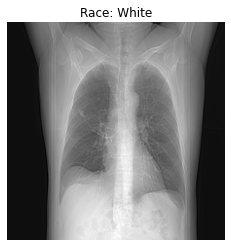

Preprocessing complete.


In [10]:
# Display one of the images
plt.imshow(X_train[0], cmap='gray')  # Use cmap='gray' for grayscale DICOM images
plt.title(f"Race: {y_train[0]}")
plt.axis('off')
plt.show()

print("Preprocessing complete.")

In [11]:
# Check the sizes of the processed datasets
print(f"Training images shape: {X_train.shape}")
print(f"Validation images shape: {X_val.shape}")

Training images shape: (34714, 224, 224)
Validation images shape: (7929, 224, 224)
